# Knowledge Graphs

In a previous chapter, you got introduced to Named entity recognition (NER) — sometimes referred to as entity chunking, extraction, or identification. This the task of identifying and categorizing key information (entities) in text. An entity can be any word or series of words that consistently refers to the same thing. Every detected entity is classified into a predetermined category.  

A natural next step in text analysis is to ask: What are the relationship among entities within a text?

Enter, knowledge graphs! A **knowledge graph** is a large semantic network. It consists of nodes that are entities such as persons, places, events, or companies, and edges that represent formalized relations between those nodes.

![knowledge_graph_example](https://d1.awsstatic.com/products/Neptune/knowledge_graph.b0e9408219d92f2ca3c7a05cccf9a5a72e34ddbd.png)

Steps to building a knowledge graph:

1. **Named-entity recognition**, finds mentions of named entities in the text and labels them with the correct type, e.g., person, organization, or location. 

2. **Coreference resolution**, identifies and resolves those coreferences to prevent duplicates and information loss.

3. **Entity linking**, links a mention in the text to a unique real-world entity in an ontology.

4. **Relation extraction**, identifies the relations between those entities. In an application scenario, you will usually consider only a few relations of interest because it is hard to extract this kind of information correctly from arbitrary text.

![knowledge_graph_process](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781492074076/files/assets/btap_1202.png)

Assume you are working in the financial business and want to track news on mergers and acquisitions. It would be great if you could automatically identify company names and the kind of deals they are involved in. Let's explore how to build a simple pipeline to build a knowledge graph. We will focus on the NER and relationship extractions steps.

In [1]:
text = "Fujitsu, a competitor of NEC, acquired Fairchild Corp."

After data cleaning, we can start with the first step of our information extraction process: named-entity recognition. 
spaCy provides trained NER models for many languages. The English models have been trained on the large OntoNotes5 corpus containing 18 different entity types. 


The NER tagger is enabled by default when you load a language model. Let’s start by initializing an nlp object with the standard (large) English model en_core_web_lg and print the components of the NLP pipeline.

In [2]:
import spacy
nlp = spacy.load('en_core_web_lg')
print(*nlp.pipeline, sep='\n')

('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec object at 0x000002854589CBF0>)
('tagger', <spacy.pipeline.tagger.Tagger object at 0x0000028545329250>)
('parser', <spacy.pipeline.dep_parser.DependencyParser object at 0x0000028546B60C80>)
('attribute_ruler', <spacy.pipeline.attributeruler.AttributeRuler object at 0x0000028546C96ED0>)
('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer object at 0x0000028546DBF590>)
('ner', <spacy.pipeline.ner.EntityRecognizer object at 0x0000028546B60C10>)


Once the text is processed, we can access the named entities directly with doc.ents. Each entity has a text and a label describing the entity type. These attributes are used in the last line in the following code to print the list of entities recognized in this text:

In [3]:
doc = nlp(text)
print(*[(e.text, e.label_) for e in doc.ents], sep=' ')

('Fujitsu', 'ORG') ('NEC', 'ORG') ('Fairchild Corp.', 'ORG')


With spaCy’s neat visualization module displacy, we can generate a visual representation of the sentence and its named entities. This is helpful to inspect the result:

In [4]:
from spacy import displacy
displacy.render(doc, style='ent')

## Relationship extraction

To capture the relationship among entities there are many methods. We know nothing about the relations between the entities.

If we take a look at the sentences relations are mostly triples of the form (Entity, Action, Entity).

We will explore two ways for pattern-based relation extraction. 
1. The first and simpler way searches for token phrases of the form “subject-predicate-object.” 
2. The second one uses the syntactical structure of a sentence, the dependency tree, to get more precise results at the price of more complex rules. 

Relation extraction is a complicated problem because of the ambiguity of natural language and the many different kinds and variations of relations. Model-based approaches to relation extraction are a current topic in research.

In [5]:
from spacy.tokens import Token
from spacy import Language

Token.set_extension('ref_n', default='', force = True)
Token.set_extension('ref_t', default='', force = True)

@Language.component("init_coref")
def init_coref(doc):
    for e in doc.ents:
        if e.label_ in ['ORG', 'GOV', 'PERSON']:
            e[0]._.ref_n, e[0]._.ref_t = e.text, e.label_
    return doc

In [6]:
def reset_pipeline(nlp, pipes):
    # remove all custom pipes
    custom_pipes = [pipe for (pipe, _) in nlp.pipeline
                    if pipe not in ['tagger', 'parser', 'ner',
                                    'tok2vec', 'attribute_ruler', 'lemmatizer']]
    for pipe in custom_pipes:
        _ = nlp.remove_pipe(pipe)
    # re-add specified pipes
    for pipe in pipes:
        if 'neuralcoref' == pipe or 'neuralcoref' in str(pipe.__class__):
            nlp.add_pipe(pipe, name='neural_coref')
        else:
            nlp.add_pipe(pipe)

    print(f"Model: {nlp.meta['name']}, Language: {nlp.meta['lang']}")
    print(*nlp.pipeline, sep='\n')
    
reset_pipeline(nlp, ['init_coref'])

Model: core_web_lg, Language: en
('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec object at 0x000002854589CBF0>)
('tagger', <spacy.pipeline.tagger.Tagger object at 0x0000028545329250>)
('parser', <spacy.pipeline.dep_parser.DependencyParser object at 0x0000028546B60C80>)
('attribute_ruler', <spacy.pipeline.attributeruler.AttributeRuler object at 0x0000028546C96ED0>)
('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer object at 0x0000028546DBF590>)
('ner', <spacy.pipeline.ner.EntityRecognizer object at 0x0000028546B60C10>)
('init_coref', <function init_coref at 0x0000028546E07420>)


### Using a pattern-based matcher

spaCy’s rule-based matcher allows us to find patterns that not only can involve the textual tokens but also their properties, like the lemma or part of speech. To use it, we must first define a matcher object. Then we can add rules with token patternsto the matcher:



In [7]:
from spacy.matcher import Matcher

matcher = Matcher(nlp.vocab)

acq_synonyms = ['acquire', 'buy', 'purchase']
pattern = [{'_': {'ref_t': 'ORG'}}, # subject
           {'_': {'ref_t': {'NOT_IN': ['ORG']}}, 'OP': '*'},
           {'POS': 'VERB', 'LEMMA': {'IN': acq_synonyms}},
           {'_': {'ref_t': {'NOT_IN': ['ORG']}}, 'OP': '*'},
           {'_': {'ref_t': 'ORG'}}] # object
matcher.add('acquires', [pattern])

The first pattern is for the acquires relation. It returns all spans consisting of an organization, followed by arbitrary tokens that are not organizations, a verb matching several synonyms of acquire, again arbitrary tokens, and finally the second organization.

In [8]:
def extract_rel_match(doc, matcher):
    for sent in doc.sents:
        for match_id, start, end in matcher(sent):
            span = sent[start:end]  # matched span
            pred = nlp.vocab.strings[match_id] # rule name
            subj, obj = span[0], span[-1]
            if pred.startswith('rev-'): # reversed relation
                subj, obj = obj, subj
                pred = pred[4:]
            yield ((subj._.ref_n, subj._.ref_t), pred, 
                   (obj._.ref_n, obj._.ref_t))

Testing our function, seems to yield good results!

In [9]:
text = "Fairchild Corp was acquired by Fujitsu."
print(*extract_rel_match(nlp(text), matcher), sep='\n')

(('Fairchild Corp', 'ORG'), 'acquires', ('Fujitsu', 'ORG'))


Let's try another example.

In [10]:
text = "Fujitsu, a competitor of NEC, acquired Fairchild Corp."
print(*extract_rel_match(nlp(text), matcher), sep='\n')

(('NEC', 'ORG'), 'acquires', ('Fairchild Corp.', 'ORG'))


Not quite what we wanted! Our rule wasn’t made for passive clauses (“was acquired by”) where the subject and object switch positions. We also cannot handle insertions containing named entities or negations because they produce false matches.

In [11]:
print(*extract_rel_match(doc, matcher), sep='\n')

To treat those cases correctly, we need knowledge about the syntactical structure of the sentence. And we get that from the dependency tree.

### Using dependency trees

The grammatical rules of a language impose a syntactical structure on each sentence. Each word serves a certain role in relation to the other words. A noun, for example, can be the subject or the object in a sentence; it depends on its relation to the verb. In linguistic theory, the words of a sentence are hierarchically interdependent, and the task of the parser in an NLP pipeline is to reconstruct these dependencies. The result is a dependency tree, which can also be visualized by displacy:

In [12]:
displacy.render(doc, style="dep",options={'compact': False, 'distance': 100})

Each node in the dependency tree represents a word. The edges are labeled with the dependency information. The root is usually the predicate of the sentence, in this case acquired, having a subject (nsubj) and an object (obj) as direct children. This first level, root plus children, already represents the essence of the sentence 

```Fujitsu acquired Fairchild Corp.```

Note: The values of the dependency labels depend on the corpus the parser model was trained on. They are also language dependent because different languages have different grammar rules. So, you definitely need to check which tag set is used by the dependency parser.

Let’s also take a look at the example with the passive clause. 

```Fairchil was aquired by Fujitsu```

In this case, the auxiliary verb (auxpass) signals that acquired was used in passive form and Fairchild is the passive subject (nsubjpass):

In [13]:
text2 = "Fujitsu, a competitor of NEC, acquired Fairchild Corp."
doc2 = nlp(text2)
displacy.render(doc2, style='dep',
                options={'compact': False, 'distance': 100})

Let's create a function that implements a rule to identify verb-based relations like acquires based on the dependencies. 

In [14]:

# Actually we search for the shortest path between the
# subject running through our predicate (verb) to the object.
# subject and object are organizations in our examples.

# Here are the three helper functions omitted in the book:
# - bfs: breadth first searching the closest subject/object 
# - is_passive: checks if noun or verb is in passive form
# - find_subj: searches left part of tree for subject
# - find_obj: searches right part of tree for object

from collections import deque

def bfs(root, ent_type, deps, first_dep_only=False):
    """Return first child of root (included) that matches
    ent_type and dependency list by breadth first search.
    Search stops after first dependency match if first_dep_only
    (used for subject search - do not "jump" over subjects)"""
    to_visit = deque([root]) # queue for bfs

    while len(to_visit) > 0:
        child = to_visit.popleft()
        # print("child", child, child.dep_)
        if child.dep_ in deps:
            if child._.ref_t == ent_type:
                return child
            elif first_dep_only: # first match (subjects)
                return None
        elif child.dep_ == 'compound' and \
             child.head.dep_ in deps and \
             child._.ref_t == ent_type: # check if contained in compound
            return child
        to_visit.extend(list(child.children))
    return None

def is_passive(token):
    if token.dep_.endswith('pass'): # noun
        return True
    for left in token.lefts: # verb
        if left.dep_ == 'auxpass':
            return True
    return False

def find_subj(pred, ent_type, passive):
    """Find closest subject in predicates left subtree or
    predicates parent's left subtree (recursive).
    Has a filter on organizations."""
    for left in pred.lefts:
        if passive: # if pred is passive, search for passive subject
            subj = bfs(left, ent_type, ['nsubjpass', 'nsubj:pass'], True)
        else:
            subj = bfs(left, ent_type, ['nsubj'], True)
        if subj is not None: # found it!
            return subj
    if pred.head != pred and not is_passive(pred): 
        return find_subj(pred.head, ent_type, passive) # climb up left subtree
    else:
        return None

def find_obj(pred, ent_type, excl_prepos):
    """Find closest object in predicates right subtree.
    Skip prepositional objects if the preposition is in exclude list.
    Has a filter on organizations."""
    for right in pred.rights:
        obj = bfs(right, ent_type, ['dobj', 'pobj', 'iobj', 'obj', 'obl'])
        if obj is not None:
            if obj.dep_ == 'pobj' and obj.head.lemma_.lower() in excl_prepos: # check preposition
                continue
            return obj
    return None

def extract_rel_dep(doc, pred_name, pred_synonyms, excl_prepos=[]):
    for token in doc:
        if token.pos_ == 'VERB' and token.lemma_ in pred_synonyms:
            pred = token
            passive = is_passive(pred)
            subj = find_subj(pred, 'ORG', passive)
            if subj is not None:
                obj = find_obj(pred, 'ORG', excl_prepos)
                if obj is not None:
                    if passive: # switch roles
                        obj, subj = subj, obj
                    yield ((subj._.ref_n, subj._.ref_t), pred_name, 
                           (obj._.ref_n, obj._.ref_t))

In [15]:
text = """Fujitsu said that Schlumberger Ltd has arranged 
to sell its stake in Fairchild Inc."""
doc = nlp(text)
print(*extract_rel_dep(doc, 'sells', ['sell']), sep='\n')

(('Fujitsu', 'ORG'), 'sells', ('Fairchild Inc.', 'ORG'))


## Creating the Knowledge Graph

Now that we know how to extract certain relationships, we can put everything together and create a knowledge graph our simple text.

We then define one function to extract all relationships. One relationship ('sub-sidiary of') is covered by a matcher, and the two other ('acquiring','selling') by the dependency-based matching algorithm. 

In [16]:
matcher = Matcher(nlp.vocab)
subs_synonyms = ['subsidiary', 'unit']
pattern1 = [{'_': {'ref_t': 'ORG'}}, # subject
           {'_': {'ref_t': {'NOT_IN': ['ORG']}},
            'POS': {'NOT_IN': ['VERB']}, 'OP': '*'},
           {'LOWER': {'IN': subs_synonyms}}, {'TEXT': 'of'},
           {'_': {'ref_t': {'NOT_IN': ['ORG']}},
            'POS': {'NOT_IN': ['VERB']}, 'OP': '*'},
           {'_': {'ref_t': 'ORG'}}]  # object
pattern2 = [{'_': {'ref_t': 'ORG'}}, # subject
           {'LOWER': {'IN': subs_synonyms}}, # predicate
           {'_': {'ref_t': 'ORG'}}] # object
matcher.add('subsidiary-of',[pattern1, pattern2])

def extract_rels(doc):
    yield from extract_rel_match(doc, matcher)
    yield from extract_rel_dep(doc, 'acquires', acq_synonyms, ['to', 'from'])
    yield from extract_rel_dep(doc, 'sells', ['sell'], ['to', 'from'])

The remaining steps to extract the relations, convert them into a NetworkX graph.

In [17]:
text = """Fujitsu, a competitor of NEC, acquired Fairchild Corp.Fujitsu said that Schlumberger Ltd has arranged 
to sell its stake in Fairchild Inc. Fujitsu plans to acquire 80% of Fairchild Corp, an industrial unit 
of Schlumberger. The Schlumberger unit Fairchild Corp received an offer."""
doc = nlp(text)

rels = []
for r in extract_rels(doc):   
    rels.append(r)
    print(r)

(('Schlumberger', 'ORG'), 'subsidiary-of', ('Fairchild Corp', 'ORG'))
(('Fujitsu', 'ORG'), 'acquires', ('Fairchild Corp', 'ORG'))


In [18]:
# Unpack subject and object 
rels_unpacked = [(*subj, pred, *obj) for (subj, pred, obj) in rels]
rels_unpacked

[('Schlumberger', 'ORG', 'subsidiary-of', 'Fairchild Corp', 'ORG'),
 ('Fujitsu', 'ORG', 'acquires', 'Fairchild Corp', 'ORG')]

In [19]:
import pandas as pd
# create data frame
rel_df = pd.DataFrame.from_records(rels_unpacked, columns=('subj', 'subj_type', 'pred', 'obj', 'obj_type'))
rel_df

,subj,subj_type,pred,obj,obj_type
0,Schlumberger,ORG,subsidiary-of,Fairchild Corp,ORG
1,Fujitsu,ORG,acquires,Fairchild Corp,ORG


### Visualizing the graph

Actually, this DataFrame already represents the list of edges for our graph. 



In [20]:
#!pip install pyvis

{('Schlumberger',
  'Fairchild Corp'): Text(0.24398983154824877, 0.29579231040770737, 'subsidiary-of'),
 ('Fujitsu',
  'Fairchild Corp'): Text(0.2560101684517516, -0.3355692800742174, 'acquires')}

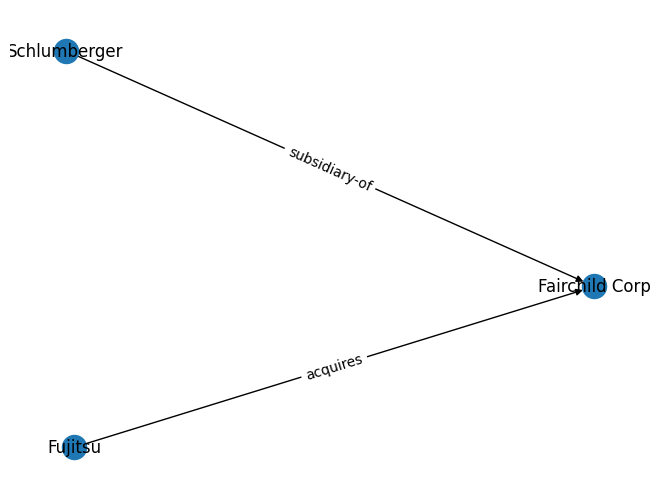

In [21]:
import networkx as nx

graph = nx.MultiDiGraph()

for i, row in rel_df.iterrows():
    graph.add_node(row['subj'], Type=row['subj_type'])
    graph.add_node(row['obj'], Type=row['obj_type'])
    _ = graph.add_edge(row['subj'], row['obj'], Rel=row['pred'])

pos = nx.spring_layout(graph)  
nx.draw(graph,pos, with_labels = True)
nx.draw_networkx_edge_labels(graph,pos,edge_labels={(u,v):w for u,v,w in graph.edges(data='Rel')})

For the visualization you could also use [PyVis](https://pyvis.readthedocs.io/en/latest/index.html), an interactive network visualization python package which takes the NetworkX graph as input. It also provides multiple styling options to customize the nodes, edges and even the complete layout. 

In [22]:
from pyvis.network import Network
network = Network(notebook=True)
network.from_nx(graph)
network.show('futjitsu_network_example.html')

ModuleNotFoundError: No module named 'pyvis'

## Final comments

Voila! You have build your first knowledge graph! It does a good job on capturing our relationships but there is room for improvement. How do you account for duplicate relationships? How can this be extended to full documents? 

This is an open area of research and there are many approaches to improve and automate some of the steps we've taken. Below you will find additional resources to get you started.

## Storing your results

Finally, you could store the graph in a graph database as the backend of a knowledge-based application. Such graph databases store the data either as RDF triples (triple stores) or in the form of a property graph, where nodes and edges can have arbitrary attributes. 

Commonly used graph databases are, for example, GraphDB (triple store), Neo4j, and Grakn (property graphs). For example, 

![graphs](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781617295645/files/OEBPS/Images/CH12_F04_Negro.png)



## Addtional Resources:
* [From Text to Knowledge: The Information Extraction Pipeline (with Neo4j)](https://towardsdatascience.com/from-text-to-knowledge-the-information-extraction-pipeline-b65e7e30273e)
* [Different Ways of Doing Relation Extraction from Text](https://medium.com/@andreasherman/different-ways-of-doing-relation-extraction-from-text-7362b4c3169e)
* [Visualizing Networks in Python](https://towardsdatascience.com/visualizing-networks-in-python-d70f4cbeb259)


#### Transformers, Graph Databases, and  Neojs4
* [Create a Graph database in Neo4j using Python](https://towardsdatascience.com/create-a-graph-database-in-neo4j-using-python-4172d40f89c4)
* [How to Build a Knowledge Graph with Neo4J and Transformers](https://towardsdatascience.com/how-to-build-a-knowledge-graph-with-neo4j-and-transformers-72b9471d6969)
* [Building a Knowledge Graph Using BERT Based NER and Neo4j, Then Predict Unknown Links](https://medium.com/@derrickfwang/building-a-knowledge-graph-using-bert-based-ner-and-neo4j-then-predict-unknown-links-94f43fc2f9c1)